# Convolutional Neural Networks
This notebook will guide you through the use of the `keras` package to train convolutional neural networks for handwritten digits classification. You are going to use the `mnist` dataset from LeCun et al. 1998.

## Loading the packages

In [3]:
#%pip install tensorflow --upgrade
#%pip install keras --upgrade

import numpy as np
from matplotlib import pyplot as pl

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input
from scipy import stats

%matplotlib inline

First, create some useful functions

In [4]:
def build_grid_of_images(array):
    assert len(array.shape) == 3
    dim_0 = np.sqrt(array.shape[0])
    assert dim_0.is_integer()

    temp_out = np.reshape(array, (dim_0, dim_0, array.shape[1], array.shape[2]))
    temp_out = np.rollaxis(temp_out, 1, 3)
    return np.reshape(temp_out, (dim_0*array.shape[1], dim_0*array.shape[2]))

def plot_conv_layer_output(temp_out, title):
    temp_to_plot = build_grid_of_images(temp_out)
    pl.imshow(temp_to_plot, interpolation='nearest', cmap=pl.get_cmap('Greys'))
    ax = pl.gca()
    ax.set_xticks(np.arange(-0.5, temp_to_plot.shape[0]+0.5, temp_out.shape[1]))
    ax.set_yticks(np.arange(-0.5, temp_to_plot.shape[0]+0.5, temp_out.shape[2]))
    pl.grid()
    pl.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
    pl.title(title)

def plot_dense_layer_output(temp_out, title):
    pl.bar(np.arange(temp_out.shape[1])-0.4, temp_out[0,:])
    pl.xlim(-0.5, temp_out.shape[1])
    pl.grid()
    pl.title(title)

Load the `mnist` dataset and normalize in the range [0, 1]

In [5]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

n_train, height, width = X_train.shape
n_test, _, _ = X_test.shape

X_train = X_train.reshape(n_train, height, width, 1).astype('float32')
X_test = X_test.reshape(n_test, height, width, 1).astype('float32')

X_train /= 255.0
X_test /= 255.0

n_classes = 10

print(n_train, 'train samples')
print(n_test, 'test samples')

# convert class vectors to binary class matrices
Y_train = to_categorical(y_train, n_classes)
Y_test = to_categorical(y_test, n_classes)

60000 train samples
10000 test samples


In [9]:
print('X_train.shape = ', X_train.shape)
print('Y_train.shape = ', Y_train.shape)
print('X_test.shape = ', X_test.shape)
print('Y_test.shape = ', Y_test.shape)

X_train.shape =  (60000, 28, 28, 1)
Y_train.shape =  (60000, 10)
X_test.shape =  (10000, 28, 28, 1)
Y_test.shape =  (10000, 10)


Create the CNN and show its architecture

In [7]:
l0 = Input(shape=(height, width, 1), name='l0')

l1 = Conv2D(32, (2, 2), padding='same', activation='relu', name='l1')(l0)
l1_mp = MaxPooling2D(pool_size=(2, 2), name='l1_mp')(l1)

l2 = Conv2D(32, (2, 2), padding='same', activation='relu', name='l2')(l1)
l2_mp = MaxPooling2D(pool_size=(2, 2), name='l2_mp')(l2)

l3 = Conv2D(32, (2, 2), padding='same', activation='relu', name='l3')(l2)
l3_mp = MaxPooling2D(pool_size=(2, 2), name='l3_mp')(l3)

flat = Flatten(name='flat')(l3_mp)

l4 = Dense(128, activation='relu', name='l4')(flat)
l4_drop = Dropout(0.5)(l4)

l5 = Dense(n_classes, activation='softmax', name='l5')(l4_drop)

model = Model(inputs=l0, outputs=l5)
model.summary()

2024-05-10 15:21:05.119004: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-10 15:21:05.368272: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ l0 (InputLayer)                 │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l1 (Conv2D)                     │ (None, 28, 28, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l2 (Conv2D)                     │ (None, 28, 28, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l3 (Conv2D)                     │ (None, 28, 28, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l3_mp (MaxPooling2D)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flat (Flatten)                  │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l4 (Dense)                      │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l5 (Dense)                      │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 812,650 (3.10 MB)

 Trainable params: 812,650 (3.10 MB)

 Non-trainable params: 0 (0.00 B)

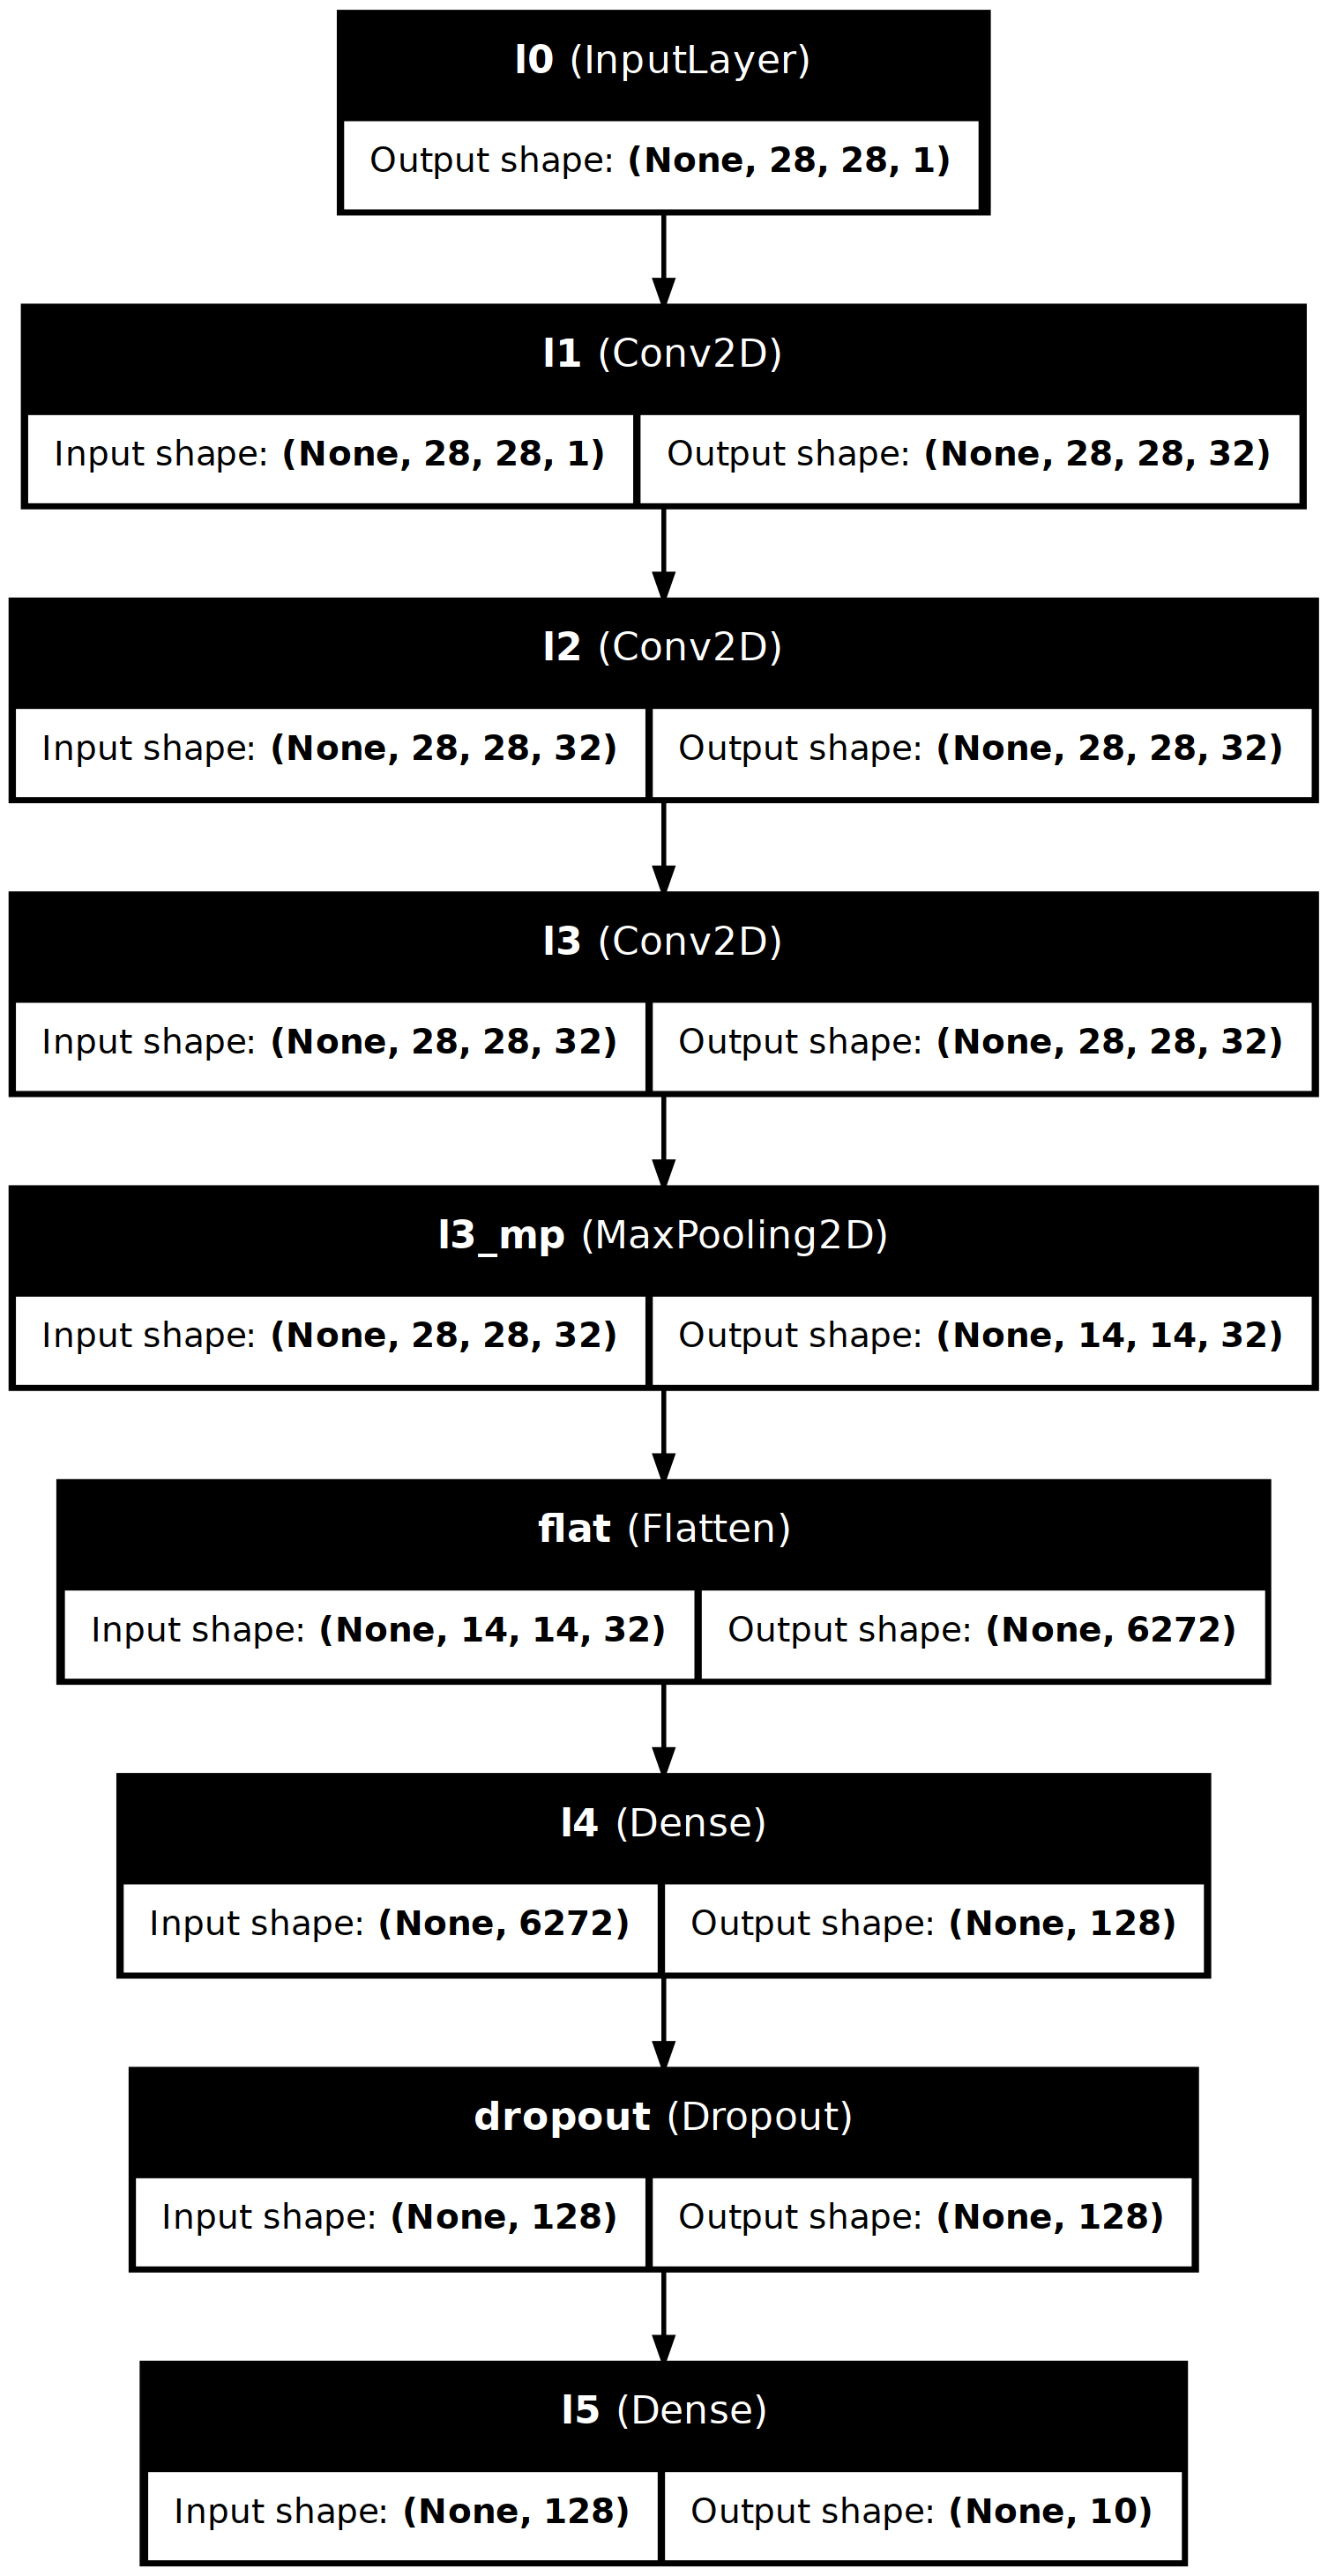

In [8]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(model, show_shapes=True, show_layer_names=True)

Define some constants and train de CNN

In [73]:
batch_size = 128
n_epoch = 4

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epoch, verbose=1, validation_split=0.1)

Epoch 1/4
422/422 [==============================] - 159s 373ms/step - loss: 0.2125 - accuracy: 0.9351 - val_loss: 0.0454 - val_accuracy: 0.9870
Epoch 2/4
422/422 [==============================] - 162s 384ms/step - loss: 0.0667 - accuracy: 0.9813 - val_loss: 0.0295 - val_accuracy: 0.9910
Epoch 3/4
422/422 [==============================] - 163s 386ms/step - loss: 0.0476 - accuracy: 0.9864 - val_loss: 0.0333 - val_accuracy: 0.9907
Epoch 4/4
422/422 [==============================] - 164s 389ms/step - loss: 0.0381 - accuracy: 0.9893 - val_loss: 0.0319 - val_accuracy: 0.9905


Show the performance of the model

Test score: 0.02639828249812126
Test accuracy: 0.9921000003814697


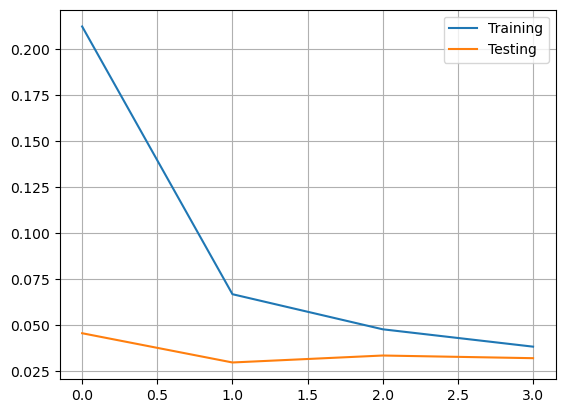

In [74]:
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Testing')
pl.legend()
pl.grid()

score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Confusion matrix

In [75]:
from sklearn.metrics import confusion_matrix

pred = model.predict(X_test)
print('pred.shape = ', pred.shape)
pred = np.argmax(pred, axis=-1)
confusion_matrix(y_test, pred)

313/313 [==============================] - 10s 32ms/step
pred.shape =  (10000, 10)


array([[ 976,    0,    0,    0,    0,    0,    1,    0,    2,    1],
       [   0, 1130,    1,    4,    0,    0,    0,    0,    0,    0],
       [   1,    2, 1025,    0,    0,    0,    0,    3,    1,    0],
       [   0,    0,    1, 1006,    0,    1,    0,    0,    2,    0],
       [   0,    0,    0,    0,  970,    0,    1,    1,    2,    8],
       [   0,    0,    0,    7,    0,  881,    1,    0,    2,    1],
       [   1,    1,    0,    1,    0,    5,  944,    0,    6,    0],
       [   0,    2,    2,    3,    1,    0,    0, 1015,    1,    4],
       [   1,    0,    1,    1,    0,    0,    0,    0,  970,    1],
       [   0,    0,    0,    0,    2,    2,    0,    0,    1, 1004]],
      dtype=int64)

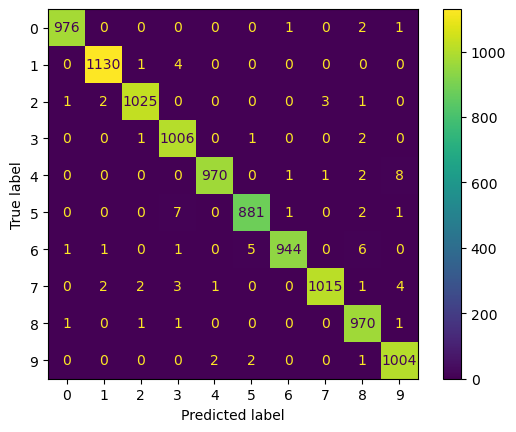

In [76]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred))
disp.plot()
pl.show()